# CS 171 Final Project - TACO Trash Classification
### Waste Classification with Classical ML and CNNs

**Author:** Lwin Moe  
**Date:** December 4, 2025

---

## Project Overview

This notebook presents the complete data preprocessing and model construction pipeline for the **TACO dataset** using cropped object images. The goal is to classify waste images into 6 categories: Cardboard, Glass, Metal, Paper, Plastic, and Trash.

### Research Question
*How effectively can machine learning models classify waste images for automated sorting, and how do classical ML approaches compare to deep learning (CNNs)?*

### Dataset
- **TACO (Trash Annotations in Context)**: Real-world waste images cropped using bounding boxes
- **Classes**: Cardboard, Glass, Metal, Paper, Plastic, Trash
- **Image Size**: Cropped objects resized to 200x200 pixels

### Models Implemented
1. **Classical ML** (using scikit-learn):
   - Logistic Regression
   - Random Forest
   - Majority Voting Ensemble

2. **Deep Learning** (using PyTorch):
   - CNN with 4 convolutional blocks, batch normalization, dropout, and data augmentation

# Part 1: Data Preprocessing

In this part, we load and organize our dataset for machine learning.  
The prepared dataset from CS171_TACO_DataPreparation is provided in three CSV files:

- train.csv
- val.csv
- test.csv

Each CSV contains two columns:

- **filepath** - path to an image file  
- **label** - the TrashNet class name

Each image has dimensions of 200x200.

The 6 TrashNet classes are:
1. **Cardboard** - Paper boxes, corrugated cartons
2. **Glass** - Glass bottles, jars, cups
3. **Metal** - Cans, lids, aluminum foil, scrap metal
4. **Paper** - Paper bags, magazines, newspapers
5. **Plastic** - Plastic bottles, containers, wrappers
6. **Trash** - Non-recyclable garbage, food waste

Example:
| filepath | label |
|---|---|
| TACO_crops/Plastic/000086.JPG | Plastic |
| TACO_crops/Metal/000087.JPG | Metal |

### **Libraries**

In [56]:
# Standard libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from tqdm import tqdm
from collections import Counter

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("All libraries imported successfully!")

# Set up device for PyTorch
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

All libraries imported successfully!
Using device: mps


### **Configuration and Data Loading**

Set up paths and load the pre-processed CSV splits.

In [57]:
# Configuration
BASE_PATH = "./"
DATA_DIR = "./TACO_crops"
SPLITS_DIR = "./splits_crops"

# TrashNet 6 classes (mapped from TACO)
CLASSES = ['Cardboard', 'Glass', 'Metal', 'Paper', 'Plastic', 'Trash']
NUM_CLASSES = len(CLASSES)

IMG_SIZE = 200
BATCH_SIZE = 32
NUM_EPOCHS = 70
LEARNING_RATE = 0.0003

# Load CSV splits
train_df = pd.read_csv(os.path.join(SPLITS_DIR, "train.csv"))
val_df = pd.read_csv(os.path.join(SPLITS_DIR, "val.csv"))
test_df = pd.read_csv(os.path.join(SPLITS_DIR, "test.csv"))

# Fix filepaths
def fix_filepath(fp):
    if BASE_PATH and not fp.startswith(BASE_PATH):
        return os.path.join(BASE_PATH, fp)
    return fp

train_df['filepath'] = train_df['filepath'].apply(fix_filepath)
val_df['filepath'] = val_df['filepath'].apply(fix_filepath)
test_df['filepath'] = test_df['filepath'].apply(fix_filepath)

# Create label index mapping
class_to_idx = {cls: i for i, cls in enumerate(CLASSES)}
train_df['label_idx'] = train_df['label'].map(class_to_idx)
val_df['label_idx'] = val_df['label'].map(class_to_idx)
test_df['label_idx'] = test_df['label'].map(class_to_idx)

print(f"Dataset splits loaded:")
print(f"  Train: {len(train_df):4d} samples")
print(f"  Val:   {len(val_df):4d} samples")
print(f"  Test:  {len(test_df):4d} samples")

Dataset splits loaded:
  Train: 2621 samples
  Val:    562 samples
  Test:   562 samples


### **Verify Dataset and Class Distribution**

Check that file paths are valid and display the class distribution.

In [58]:
# Verify file paths exist
print("Verifying file paths...")
sample_paths = train_df['filepath'].head(5)
for i, fp in enumerate(sample_paths):
    exists = os.path.exists(fp)
    print(f"  {i+1}. {fp} -> {'EXISTS' if exists else 'NOT FOUND'}")

# Count images per class
print(f"\nTACO Dataset Class Distribution:")
print("-" * 40)

class_counts = {}
for class_name in CLASSES:
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.exists(class_path):
        count = len([f for f in os.listdir(class_path)
                    if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        class_counts[class_name] = count
        print(f"  {class_name:12s}: {count:4d} images")
    else:
        class_counts[class_name] = 0
        print(f"  {class_name:12s}: NOT FOUND")

total_images = sum(class_counts.values())
print("-" * 40)
print(f"  {'TOTAL':12s}: {total_images:4d} images")

# Check for imbalance
min_class = min(class_counts, key=class_counts.get)
max_class = max(class_counts, key=class_counts.get)
if class_counts[min_class] > 0:
    imbalance_ratio = class_counts[max_class] / class_counts[min_class]
    print(f"\nClass Imbalance: {imbalance_ratio:.1f}x ratio between largest and smallest class")

# ==================== BALANCE THE DATASET ====================
print("\n" + "="*50)
print("BALANCING DATASET")
print("="*50)

MAX_TRAIN = 600
MAX_VAL_TEST = 50

def balance(df, max_n):
    balanced = []
    for cls in CLASSES:
        subset = df[df["label"] == cls]
        if len(subset) > max_n:
            subset = subset.sample(max_n, random_state=42)
        balanced.append(subset)
    return pd.concat(balanced).sample(frac=1, random_state=42).reset_index(drop=True)

train_df = balance(train_df, MAX_TRAIN)
val_df = balance(val_df, MAX_VAL_TEST)
test_df = balance(test_df, MAX_VAL_TEST)

print(f"\nBalanced Training set:")
print(train_df['label'].value_counts())
print(f"\nBalanced Validation set:")
print(val_df['label'].value_counts())
print(f"\nBalanced Test set:")
print(test_df['label'].value_counts())

print(f"\nFinal dataset sizes:")
print(f"  Train: {len(train_df):4d} samples")
print(f"  Val:   {len(val_df):4d} samples")
print(f"  Test:  {len(test_df):4d} samples")

Verifying file paths...
  1. ./TACO_crops/Trash/crop_1208_3727.jpg -> EXISTS
  2. ./TACO_crops/Plastic/crop_386_1351.jpg -> EXISTS
  3. ./TACO_crops/Metal/crop_1123_3450.jpg -> EXISTS
  4. ./TACO_crops/Trash/crop_460_1636.jpg -> EXISTS
  5. ./TACO_crops/Plastic/crop_394_1410.jpg -> EXISTS

TACO Dataset Class Distribution:
----------------------------------------
  Cardboard   :  197 images
  Glass       :  200 images
  Metal       :  488 images
  Paper       :  235 images
  Plastic     : 1650 images
  Trash       :  975 images
----------------------------------------
  TOTAL       : 3745 images

Class Imbalance: 8.4x ratio between largest and smallest class

BALANCING DATASET

Balanced Training set:
label
Trash        600
Plastic      600
Metal        342
Paper        164
Glass        140
Cardboard    138
Name: count, dtype: int64

Balanced Validation set:
label
Plastic      50
Trash        50
Metal        50
Paper        36
Glass        30
Cardboard    29
Name: count, dtype: int64

Ba

### **Sample Images from Each Category**

Visualize sample images from each waste category to understand the dataset.

Sample Images from Each Waste Category


/var/folders/2l/kxwmbqpj1gs1hcrvl2v35dd80000gn/T/ipykernel_55280/1780346840.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


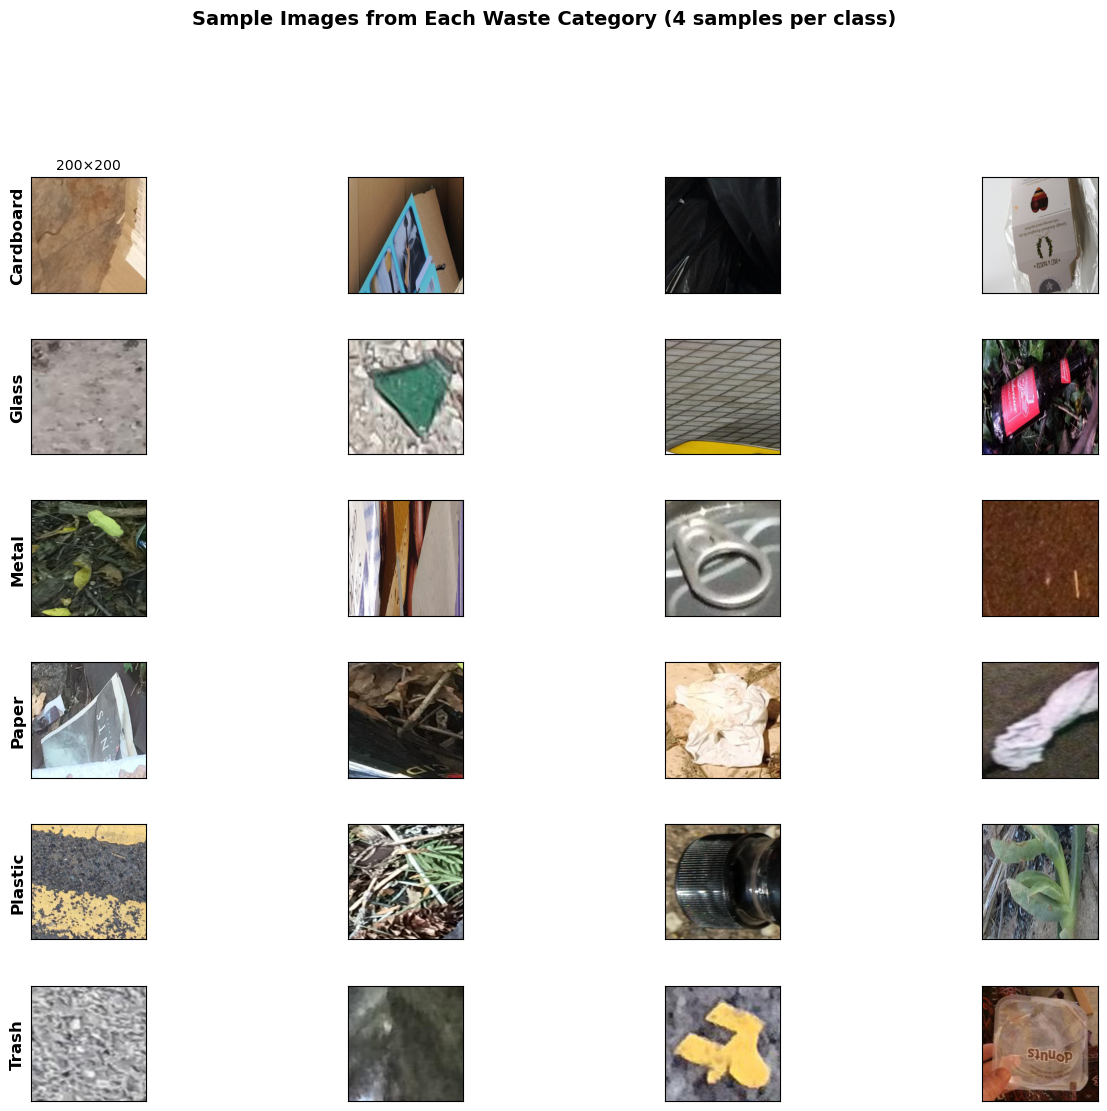


Training Set Class Distribution:
----------------------------------------
  Cardboard   :  138 samples
  Glass       :  140 samples
  Metal       :  342 samples
  Paper       :  164 samples
  Plastic     :  600 samples
  Trash       :  600 samples


In [59]:
# Display sample images from each class
import matplotlib.gridspec as gridspec

print("Sample Images from Each Waste Category")
print("="*50)

# Number of samples per class to display
SAMPLES_PER_CLASS = 4

fig = plt.figure(figsize=(16, 12))
gs = gridspec.GridSpec(NUM_CLASSES, SAMPLES_PER_CLASS, hspace=0.4, wspace=0.1)

for class_idx, class_name in enumerate(CLASSES):
    # Get samples for this class from training data
    class_samples = train_df[train_df['label'] == class_name].head(SAMPLES_PER_CLASS)
    
    for sample_idx, (_, row) in enumerate(class_samples.iterrows()):
        ax = fig.add_subplot(gs[class_idx, sample_idx])
        
        try:
            img = Image.open(row['filepath']).convert('RGB')
            ax.imshow(img)
            
            # Only show class name on first image of each row
            if sample_idx == 0:
                ax.set_ylabel(class_name, fontsize=12, fontweight='bold')
            
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Show image dimensions on first sample
            if sample_idx == 0 and class_idx == 0:
                ax.set_title(f'{img.size[0]}×{img.size[1]}', fontsize=10)
                
        except Exception as e:
            ax.text(0.5, 0.5, 'Error', ha='center', va='center')
            ax.set_xticks([])
            ax.set_yticks([])

plt.suptitle('Sample Images from Each Waste Category (4 samples per class)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print class counts from training set
print("\nTraining Set Class Distribution:")
print("-"*40)
for class_name in CLASSES:
    count = len(train_df[train_df['label'] == class_name])
    print(f"  {class_name:12s}: {count:4d} samples")

### **Compute Dataset Statistics**

Calculate the mean and standard deviation of the training images for normalization.

In [60]:
# Compute dataset statistics
print("Computing normalization statistics on training set...")

channel_sum = np.zeros(3)
channel_sq_sum = np.zeros(3)
pixel_count = 0

for filepath in tqdm(train_df['filepath'].values, desc="Processing training images"):
    try:
        img = Image.open(filepath).convert("RGB").resize((IMG_SIZE, IMG_SIZE))
        img = np.array(img) / 255.0
        channel_sum += img.sum(axis=(0, 1))
        channel_sq_sum += (img ** 2).sum(axis=(0, 1))
        pixel_count += img.shape[0] * img.shape[1]
    except:
        continue

dataset_mean = channel_sum / pixel_count
dataset_std = np.sqrt(channel_sq_sum / pixel_count - dataset_mean ** 2)

print(f"\nDataset statistics (computed on training set):")
print(f"  Mean: [{dataset_mean[0]:.4f}, {dataset_mean[1]:.4f}, {dataset_mean[2]:.4f}]")
print(f"  Std:  [{dataset_std[0]:.4f}, {dataset_std[1]:.4f}, {dataset_std[2]:.4f}]")

Computing normalization statistics on training set...


Processing training images: 100%|██████████| 1984/1984 [00:02<00:00, 869.73it/s]


Dataset statistics (computed on training set):
  Mean: [0.5061, 0.4805, 0.4375]
  Std:  [0.2626, 0.2560, 0.2620]


# **Part 2: Feature Extraction for Classical ML**

Here we implement feature extraction for classical machine learning approaches. We extract features from images including:

1. **Color Histograms** - RGB channel distributions (96 features)
2. **Texture Features** - Edge statistics using gradient differences (8 features)
3. **Spatial Features** - 4x4 grid mean/std per channel (96 features)
4. **Thumbnail** - Downsampled 16x16 image (768 features)

Total: 968 features per image

These features can be used with classifiers like Logistic Regression, Random Forest, and Majority Voting Ensemble.

In [61]:
# Feature extraction functions
def extract_color_histogram(img, bins=32):
    """Extract color histogram features from image."""
    hist_features = []
    for channel in range(3):
        hist, _ = np.histogram(img[:,:,channel], bins=bins, range=(0, 1))
        hist = hist / hist.sum()  # Normalize
        hist_features.extend(hist)
    return np.array(hist_features)

def extract_texture_features(img):
    """Extract simple texture features (edge statistics)."""
    gray = np.mean(img, axis=2)
    dx = np.abs(np.diff(gray, axis=1))
    dy = np.abs(np.diff(gray, axis=0))
    features = [
        np.mean(dx), np.std(dx), np.max(dx),
        np.mean(dy), np.std(dy), np.max(dy),
        np.mean(gray), np.std(gray),
    ]
    return np.array(features)

def extract_spatial_features(img, grid_size=4):
    """Extract spatial color features by dividing image into grid."""
    h, w = img.shape[:2]
    cell_h, cell_w = h // grid_size, w // grid_size
    features = []
    for i in range(grid_size):
        for j in range(grid_size):
            cell = img[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            for c in range(3):
                features.append(np.mean(cell[:,:,c]))
                features.append(np.std(cell[:,:,c]))
    return np.array(features)

def load_and_extract_features(df, img_size=128):
    """Load images and extract multiple feature types."""
    X = []
    y = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Extracting features"):
        try:
            img = Image.open(row['filepath']).convert('RGB')
            img = img.resize((img_size, img_size))
            img_array = np.array(img) / 255.0
            
            color_hist = extract_color_histogram(img_array, bins=32)
            texture = extract_texture_features(img_array)
            spatial = extract_spatial_features(img_array, grid_size=4)
            thumbnail = np.array(img.resize((16, 16))) / 255.0
            
            all_features = np.concatenate([
                color_hist, texture, spatial, thumbnail.flatten()
            ])
            X.append(all_features)
            y.append(row['label_idx'])
        except Exception as e:
            continue
    return np.array(X), np.array(y)

# Load data with feature extraction
FEATURE_IMG_SIZE = 128

print("Extracting features from training data...")
X_train, y_train = load_and_extract_features(train_df, FEATURE_IMG_SIZE)

print("Extracting features from validation data...")
X_val, y_val = load_and_extract_features(val_df, FEATURE_IMG_SIZE)

print("Extracting features from test data...")
X_test, y_test = load_and_extract_features(test_df, FEATURE_IMG_SIZE)

print(f"\nFeature shapes:")
print(f"  X_train: {X_train.shape} ({X_train.shape[1]} features per image)")
print(f"  X_val:   {X_val.shape}")
print(f"  X_test:  {X_test.shape}")

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Features standardized (zero mean, unit variance)")

Extracting features from training data...


Extracting features: 100%|█████████████████| 1984/1984 [00:03<00:00, 600.61it/s]


Extracting features from validation data...


Extracting features: 100%|███████████████████| 245/245 [00:00<00:00, 494.42it/s]


Extracting features from test data...


Extracting features: 100%|███████████████████| 245/245 [00:00<00:00, 468.10it/s]



Feature shapes:
  X_train: (1984, 968) (968 features per image)
  X_val:   (245, 968)
  X_test:  (245, 968)
Features standardized (zero mean, unit variance)


### **Training Classical ML Models**

We train three classical machine learning models and evaluate their performance on the validation and test sets.

In [62]:
# ==================== TRAIN CLASSICAL ML MODELS ====================
print("="*60)
print("TRAINING CLASSICAL ML MODELS")
print("="*60)

# Define models
classical_models = {
    'Logistic Regression': LogisticRegression(max_iter=2000, C=1.0, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42),
}

classical_results = {}

# Train each model
for name, model in classical_models.items():
    print(f"\nTraining {name}...")
    
    # Train on training data
    model.fit(X_train_scaled, y_train)
    
    # Evaluate on validation set
    val_pred = model.predict(X_val_scaled)
    val_acc = accuracy_score(y_val, val_pred)
    
    # Evaluate on test set
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    
    classical_results[name] = {
        'model': model,
        'val_accuracy': val_acc,
        'test_accuracy': test_acc,
        'test_predictions': test_pred
    }
    
    print(f"  Validation Accuracy: {val_acc:.4f}")
    print(f"  Test Accuracy:       {test_acc:.4f}")

# ==================== MAJORITY VOTING ENSEMBLE ====================
print("\n" + "-"*60)
print("Training Majority Voting Ensemble...")

# Create ensemble with Logistic Regression and Random Forest
voters = [
    ('logreg', LogisticRegression(max_iter=2000, C=1.0, random_state=42)),
    ('rf', RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42))
]

voting_clf = VotingClassifier(estimators=voters, voting='hard')
voting_clf.fit(X_train_scaled, y_train)

# Evaluate
val_pred_voting = voting_clf.predict(X_val_scaled)
test_pred_voting = voting_clf.predict(X_test_scaled)

val_acc_voting = accuracy_score(y_val, val_pred_voting)
test_acc_voting = accuracy_score(y_test, test_pred_voting)

classical_results['Majority Voting'] = {
    'model': voting_clf,
    'val_accuracy': val_acc_voting,
    'test_accuracy': test_acc_voting,
    'test_predictions': test_pred_voting
}

print(f"  Validation Accuracy: {val_acc_voting:.4f}")
print(f"  Test Accuracy:       {test_acc_voting:.4f}")


TRAINING CLASSICAL ML MODELS

Training Logistic Regression...
  Validation Accuracy: 0.2735
  Test Accuracy:       0.2776

Training Random Forest...
  Validation Accuracy: 0.2980
  Test Accuracy:       0.2980

------------------------------------------------------------
Training Majority Voting Ensemble...
  Validation Accuracy: 0.2980
  Test Accuracy:       0.3061


# **Part 3: Convolutional Neural Network (CNN)**

Now we implement an **Enhanced CNN** for waste image classification. The architecture includes:

**Feature Extractor (4 Convolutional Blocks):**
- Block 1: Conv(3→32) + BatchNorm + ReLU + MaxPool (200→100)
- Block 2: Conv(32→64) + BatchNorm + ReLU + MaxPool (100→50)
- Block 3: Conv(64→128) + BatchNorm + ReLU + MaxPool (50→25)
- Block 4: Conv(128→256) + BatchNorm + ReLU + MaxPool (25→12)

**Classifier:**
- FC(256→128) + ReLU + Dropout(0.5)
- FC(128→6)

**Training Features:**
- Class weights for imbalanced data
- Adam optimizer with LR scheduler
- Early stopping (patience=12)
- Data augmentation (flip, rotation, affine, color jitter)

In [63]:
# CNN
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()

        self.features = nn.Sequential(
            # Conv Block 1: 3 -> 32
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),  # 200 -> 100

            # Conv Block 2: 32 -> 64
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),  # 100 -> 50

            # Conv Block 3: 64 -> 128
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),  # 50 -> 25

            # Conv Block 4: 128 -> 256
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2),  # 25 -> 12
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # Global Average Pooling
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = EnhancedCNN(num_classes=NUM_CLASSES).to(device)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


Total parameters: 423,046


### **Data Loaders with Augmentation**

Create PyTorch data loaders with data augmentation for training.

In [64]:
# Custom Dataset class
class TrashDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row['filepath']).convert('RGB')
        label = row['label_idx']
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Training transform with data augmentation (matching train_trash_classifier.py)
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),
    transforms.RandomAffine(0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

# Validation/Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=dataset_mean.tolist(), std=dataset_std.tolist())
])

# Create datasets
train_dataset = TrashDataset(train_df, transform=train_transform)
val_dataset = TrashDataset(val_df, transform=test_transform)
test_dataset = TrashDataset(test_df, transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"DataLoaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches:   {len(val_loader)}")
print(f"  Test batches:  {len(test_loader)}")

DataLoaders created:
  Train batches: 62
  Val batches:   8
  Test batches:  8


### **Training the CNN**

We train the CNN using Adam optimizer with learning rate scheduling.

In [65]:
# Compute class weights for imbalanced data
labels_np = train_df["label_idx"].values
weights = compute_class_weight("balanced", classes=np.unique(labels_np), y=labels_np)
class_weights = torch.tensor(weights, dtype=torch.float32).to(device)

print("Class weights for loss function:")
for cls, w in zip(CLASSES, weights):
    print(f"  {cls:12s}: {w:.4f}")

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

def train_model(model, train_loader, val_loader, num_epochs=100):
    best_acc = 0
    #patience = 12
    #wait = 0

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0

        for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            imgs, labels = imgs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(out, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                out = model(imgs)
                loss = criterion(out, labels)
                val_loss_total += loss.item()
                _, preds = torch.max(out, 1)
                val_total += labels.size(0)
                val_correct += (preds == labels).sum().item()

        val_loss = val_loss_total / len(val_loader)
        val_acc = val_correct / val_total

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        scheduler.step()

        print(f"Epoch [{epoch+1:3d}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping with model saving
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "best_cnn_model.pth")
            wait = 0
            print(f"  -> New best model saved! (Val Acc: {best_acc:.4f})")
        #else:
            #wait += 1
            #if wait >= patience:
                #print(f"\nEarly stopping at epoch {epoch+1}")
                #break

    print(f"\nTraining complete. Best Validation Accuracy: {best_acc:.4f}")
    return train_losses, val_losses, train_accs, val_accs

# Training the Model
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, num_epochs=NUM_EPOCHS
)

Class weights for loss function:
  Cardboard   : 2.3961
  Glass       : 2.3619
  Metal       : 0.9669
  Paper       : 2.0163
  Plastic     : 0.5511
  Trash       : 0.5511


Epoch [  1/70] Train Loss: 1.8791, Train Acc: 0.2253 | Val Loss: 1.7596, Val Acc: 0.2327
  -> New best model saved! (Val Acc: 0.2327)


Epoch [  2/70] Train Loss: 1.8594, Train Acc: 0.2036 | Val Loss: 1.7854, Val Acc: 0.2653
  -> New best model saved! (Val Acc: 0.2653)


Epoch [  3/70] Train Loss: 1.8555, Train Acc: 0.2757 | Val Loss: 1.7917, Val Acc: 0.2490


Epoch [  4/70] Train Loss: 1.8482, Train Acc: 0.2369 | Val Loss: 1.7561, Val Acc: 0.2612


Epoch [  5/70] Train Loss: 1.8466, Train Acc: 0.2591 | Val Loss: 1.7444, Val Acc: 0.2653


Epoch [  6/70] Train Loss: 1.8260, Train Acc: 0.2354 | Val Loss: 1.7715, Val Acc: 0.2816
  -> New best model saved! (Val Acc: 0.2816)


Epoch [  7/70] Train Loss: 1.8275, Train Acc: 0.2515 | Val Loss: 1.7495, Val Acc: 0.2612


Epoch [  8/70] Train Loss: 1.8302, Train Acc: 0.2374 | Val Loss: 1.7454, Val Acc: 0.2367


Epoch [  9/70] Train Loss: 1.8159, Train Acc: 0.2722 | Val Loss: 1.7435, Val Acc: 0.2816


Epoch [ 10/70] Train Loss: 1.8028, Train Acc: 0.2712 | Val Loss: 1.7513, Val Acc: 0.2571


Epoch [ 11/70] Train Loss: 1.8018, Train Acc: 0.2772 | Val Loss: 1.7242, Val Acc: 0.2776


Epoch [ 12/70] Train Loss: 1.8176, Train Acc: 0.2722 | Val Loss: 1.7568, Val Acc: 0.2980
  -> New best model saved! (Val Acc: 0.2980)


Epoch [ 13/70] Train Loss: 1.7955, Train Acc: 0.2571 | Val Loss: 1.7939, Val Acc: 0.2694


Epoch [ 14/70] Train Loss: 1.7925, Train Acc: 0.2772 | Val Loss: 1.7474, Val Acc: 0.2939


Epoch [ 15/70] Train Loss: 1.7891, Train Acc: 0.2742 | Val Loss: 1.7654, Val Acc: 0.2449


Epoch [ 16/70] Train Loss: 1.7918, Train Acc: 0.2994 | Val Loss: 1.7809, Val Acc: 0.2735


Epoch [ 17/70] Train Loss: 1.7900, Train Acc: 0.2802 | Val Loss: 1.7564, Val Acc: 0.2531


Epoch [ 18/70] Train Loss: 1.7955, Train Acc: 0.2702 | Val Loss: 1.7573, Val Acc: 0.2612


Epoch [ 19/70] Train Loss: 1.7701, Train Acc: 0.2828 | Val Loss: 1.7429, Val Acc: 0.2694


Epoch [ 20/70] Train Loss: 1.7724, Train Acc: 0.2737 | Val Loss: 1.7203, Val Acc: 0.2857


Epoch [ 21/70] Train Loss: 1.7748, Train Acc: 0.2853 | Val Loss: 1.7083, Val Acc: 0.2776


Epoch [ 22/70] Train Loss: 1.7653, Train Acc: 0.2898 | Val Loss: 1.7534, Val Acc: 0.3020
  -> New best model saved! (Val Acc: 0.3020)


Epoch [ 23/70] Train Loss: 1.7656, Train Acc: 0.2949 | Val Loss: 1.7359, Val Acc: 0.3061
  -> New best model saved! (Val Acc: 0.3061)


Epoch [ 24/70] Train Loss: 1.7573, Train Acc: 0.2933 | Val Loss: 1.6949, Val Acc: 0.3102
  -> New best model saved! (Val Acc: 0.3102)


Epoch [ 25/70] Train Loss: 1.7579, Train Acc: 0.2807 | Val Loss: 1.7585, Val Acc: 0.2857


Epoch [ 26/70] Train Loss: 1.7597, Train Acc: 0.3029 | Val Loss: 1.7466, Val Acc: 0.2612


Epoch [ 27/70] Train Loss: 1.7519, Train Acc: 0.3170 | Val Loss: 1.7559, Val Acc: 0.2694


Epoch [ 28/70] Train Loss: 1.7433, Train Acc: 0.3075 | Val Loss: 1.7702, Val Acc: 0.2735


Epoch [ 29/70] Train Loss: 1.7495, Train Acc: 0.2964 | Val Loss: 1.7398, Val Acc: 0.2898


Epoch [ 30/70] Train Loss: 1.7467, Train Acc: 0.3110 | Val Loss: 1.7035, Val Acc: 0.2694


Epoch [ 31/70] Train Loss: 1.7266, Train Acc: 0.3201 | Val Loss: 1.7709, Val Acc: 0.2776


Epoch [ 32/70] Train Loss: 1.7376, Train Acc: 0.3070 | Val Loss: 1.7209, Val Acc: 0.2776


Epoch [ 33/70] Train Loss: 1.7291, Train Acc: 0.3226 | Val Loss: 1.7318, Val Acc: 0.2694


Epoch [ 34/70] Train Loss: 1.7232, Train Acc: 0.3206 | Val Loss: 1.7291, Val Acc: 0.2898


Epoch [ 35/70] Train Loss: 1.7216, Train Acc: 0.3261 | Val Loss: 1.7341, Val Acc: 0.2776


Epoch [ 36/70] Train Loss: 1.7189, Train Acc: 0.3216 | Val Loss: 1.7816, Val Acc: 0.2816


Epoch [ 37/70] Train Loss: 1.7204, Train Acc: 0.3266 | Val Loss: 1.7679, Val Acc: 0.2857


Epoch [ 38/70] Train Loss: 1.7097, Train Acc: 0.3432 | Val Loss: 1.7410, Val Acc: 0.2939


Epoch [ 39/70] Train Loss: 1.7139, Train Acc: 0.3281 | Val Loss: 1.7426, Val Acc: 0.3020


Epoch [ 40/70] Train Loss: 1.7110, Train Acc: 0.3175 | Val Loss: 1.7161, Val Acc: 0.3184
  -> New best model saved! (Val Acc: 0.3184)


Epoch [ 41/70] Train Loss: 1.7137, Train Acc: 0.3427 | Val Loss: 1.7101, Val Acc: 0.2857


Epoch [ 42/70] Train Loss: 1.7091, Train Acc: 0.3221 | Val Loss: 1.7090, Val Acc: 0.3020


Epoch [ 43/70] Train Loss: 1.7062, Train Acc: 0.3483 | Val Loss: 1.7265, Val Acc: 0.3143


Epoch [ 44/70] Train Loss: 1.6975, Train Acc: 0.3453 | Val Loss: 1.7212, Val Acc: 0.3020


Epoch [ 45/70] Train Loss: 1.6956, Train Acc: 0.3498 | Val Loss: 1.7093, Val Acc: 0.2939


Epoch [ 46/70] Train Loss: 1.7013, Train Acc: 0.3362 | Val Loss: 1.7075, Val Acc: 0.3224
  -> New best model saved! (Val Acc: 0.3224)


Epoch [ 47/70] Train Loss: 1.7083, Train Acc: 0.3503 | Val Loss: 1.7096, Val Acc: 0.3224


Epoch [ 48/70] Train Loss: 1.7026, Train Acc: 0.3367 | Val Loss: 1.7461, Val Acc: 0.3143


Epoch [ 49/70] Train Loss: 1.6827, Train Acc: 0.3473 | Val Loss: 1.7064, Val Acc: 0.2980


Epoch [ 50/70] Train Loss: 1.6882, Train Acc: 0.3372 | Val Loss: 1.7015, Val Acc: 0.3020


Epoch [ 51/70] Train Loss: 1.6803, Train Acc: 0.3609 | Val Loss: 1.7145, Val Acc: 0.3184


Epoch [ 52/70] Train Loss: 1.6714, Train Acc: 0.3498 | Val Loss: 1.7077, Val Acc: 0.3184


Epoch [ 53/70] Train Loss: 1.6814, Train Acc: 0.3528 | Val Loss: 1.7245, Val Acc: 0.3265
  -> New best model saved! (Val Acc: 0.3265)


Epoch [ 54/70] Train Loss: 1.6841, Train Acc: 0.3538 | Val Loss: 1.7030, Val Acc: 0.3061


Epoch [ 55/70] Train Loss: 1.6713, Train Acc: 0.3690 | Val Loss: 1.7186, Val Acc: 0.3306
  -> New best model saved! (Val Acc: 0.3306)


Epoch [ 56/70] Train Loss: 1.6730, Train Acc: 0.3710 | Val Loss: 1.7099, Val Acc: 0.3224


Epoch [ 57/70] Train Loss: 1.6611, Train Acc: 0.3700 | Val Loss: 1.7122, Val Acc: 0.3224


Epoch [ 58/70] Train Loss: 1.6608, Train Acc: 0.3745 | Val Loss: 1.7089, Val Acc: 0.3061


Epoch [ 59/70] Train Loss: 1.6661, Train Acc: 0.3543 | Val Loss: 1.7095, Val Acc: 0.3143


Epoch [ 60/70] Train Loss: 1.6556, Train Acc: 0.3690 | Val Loss: 1.7123, Val Acc: 0.3102


Epoch [ 61/70] Train Loss: 1.6609, Train Acc: 0.3614 | Val Loss: 1.7021, Val Acc: 0.3061


Epoch [ 62/70] Train Loss: 1.6808, Train Acc: 0.3619 | Val Loss: 1.7144, Val Acc: 0.3102


Epoch [ 63/70] Train Loss: 1.6662, Train Acc: 0.3649 | Val Loss: 1.7158, Val Acc: 0.3224


Epoch [ 64/70] Train Loss: 1.6579, Train Acc: 0.3644 | Val Loss: 1.7114, Val Acc: 0.3224


Epoch [ 65/70] Train Loss: 1.6679, Train Acc: 0.3574 | Val Loss: 1.7141, Val Acc: 0.3224


Epoch [ 66/70] Train Loss: 1.6510, Train Acc: 0.3614 | Val Loss: 1.7051, Val Acc: 0.3184


Epoch [ 67/70] Train Loss: 1.6721, Train Acc: 0.3684 | Val Loss: 1.7132, Val Acc: 0.3224


Epoch [ 68/70] Train Loss: 1.6552, Train Acc: 0.3634 | Val Loss: 1.7220, Val Acc: 0.2980


Epoch [ 69/70] Train Loss: 1.6515, Train Acc: 0.3654 | Val Loss: 1.7115, Val Acc: 0.3224


Epoch [ 70/70] Train Loss: 1.6594, Train Acc: 0.3690 | Val Loss: 1.7091, Val Acc: 0.3184

Training complete. Best Validation Accuracy: 0.3306


### **Evaluate CNN on Test Set**

We evaluate the trained model on unseen test data to measure final performance.

In [66]:
# Evaluate
best_model = EnhancedCNN(num_classes=NUM_CLASSES).to(device)
best_model.load_state_dict(torch.load('best_cnn_model.pth'))
best_model.eval()

# Evaluate on test set
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Testing CNN"):
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc_cnn = test_correct / test_total

print(f"\n" + "="*60)
print("TEST RESULTS")
print("="*60)
print(f"\nCNN Test Accuracy: {test_acc_cnn:.4f} ({test_acc_cnn*100:.2f}%)")

/var/folders/2l/kxwmbqpj1gs1hcrvl2v35dd80000gn/T/ipykernel_55280/1352409990.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_c


TEST RESULTS

CNN Test Accuracy: 0.3184 (31.84%)


### **Classification Report**

Detailed per-class precision, recall, and F1-score.

In [67]:
# Classification Report
print("Classification Report (CNN):")
print("-" * 60)
print(classification_report(all_labels, all_preds, target_names=CLASSES))

Classification Report (CNN):
------------------------------------------------------------
              precision    recall  f1-score   support

   Cardboard       0.37      0.23      0.29        30
       Glass       0.38      0.50      0.43        30
       Metal       0.40      0.12      0.18        50
       Paper       0.12      0.17      0.14        35
     Plastic       0.39      0.26      0.31        50
       Trash       0.34      0.62      0.44        50

    accuracy                           0.32       245
   macro avg       0.34      0.32      0.30       245
weighted avg       0.34      0.32      0.30       245



### **Confusion Matrix**

Visualize the confusion matrix to see which classes are being confused with each other.

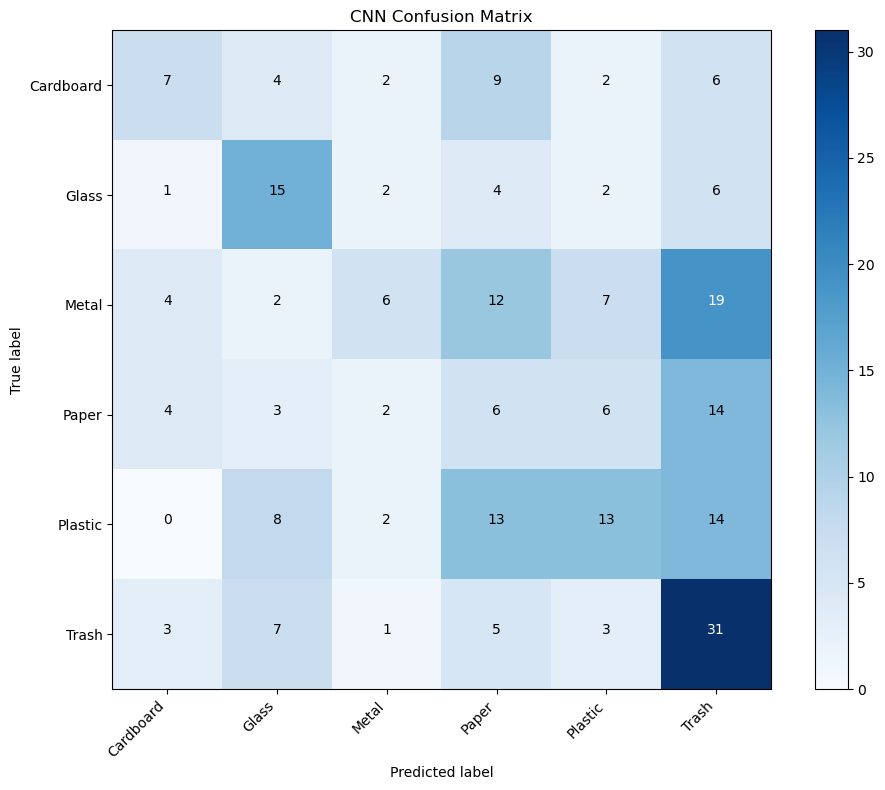


Per-Class Accuracy:
  Cardboard   : 0.2333 (23.3%)
  Glass       : 0.5000 (50.0%)
  Metal       : 0.1200 (12.0%)
  Paper       : 0.1714 (17.1%)
  Plastic     : 0.2600 (26.0%)
  Trash       : 0.6200 (62.0%)


In [68]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('CNN Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(CLASSES))
plt.xticks(tick_marks, CLASSES, rotation=45, ha='right')
plt.yticks(tick_marks, CLASSES)

# Add counts
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# Per-class accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Class Accuracy:")
for cls, acc in zip(CLASSES, per_class_acc):
    print(f"  {cls:12s}: {acc:.4f} ({acc*100:.1f}%)")

As we can see in the matrix, it shows that the model often mixes up classes, especially ones that look similar. The Trash class had the best recall (52%), probably because it’s a catch-all category. Cardboard (36.7%), Plastic (34%) and Glass (40%) did okay, but Metal (14%), Paper (14.3%) were tough for the model. 

A big pattern we saw is that the model likes to predict Trash or Plastic, which means these categories probably look very similar in TACO. This result makes sense because the TACO dataset is taken in the wild and images are messy, noisy, sometimes low-resolution, and taken from random angles with cluttered backgrounds. This is very different from clean, studio-style datasets like TrashNet.

To improve the model, we could try transfer learning with stronger pre-trained networks, add more aggressive data augmentation, or use methods like focal loss to help with class imbalance and difficult examples.

### **Training Progress**

Loss and accuracy curves over training epochs.

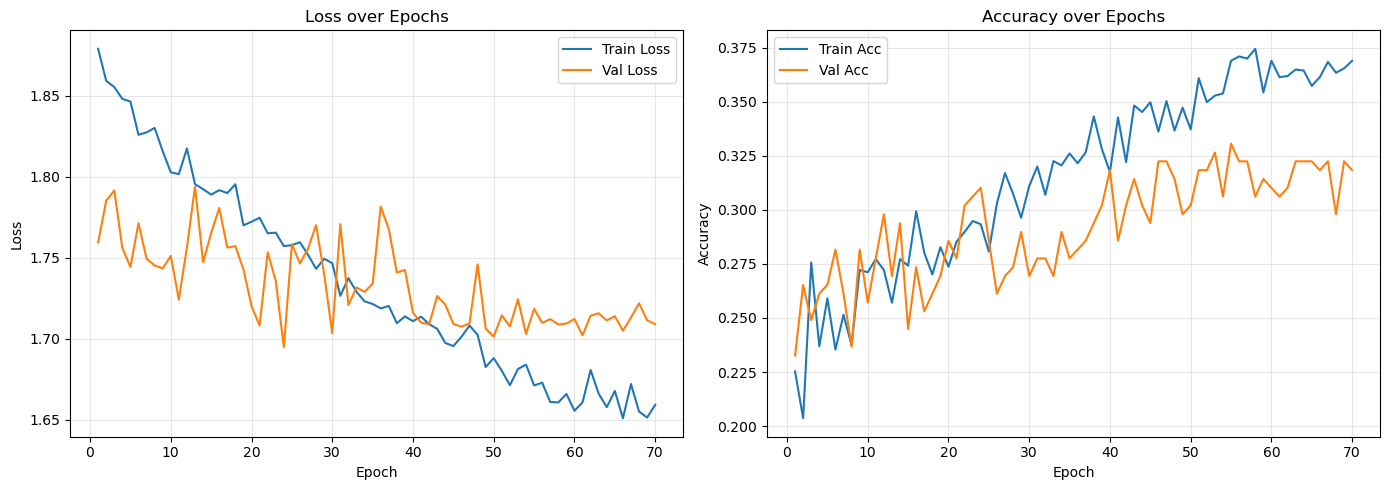


Training completed after 70 epochs
Best Validation Accuracy: 0.3306


In [70]:
# Plot Training Progress
actual_epochs = len(train_losses)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss
axes[0].plot(range(1, actual_epochs+1), train_losses, label='Train Loss')
axes[0].plot(range(1, actual_epochs+1), val_losses, label='Val Loss')
axes[0].set_title('Loss over Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(range(1, actual_epochs+1), train_accs, label='Train Acc')
axes[1].plot(range(1, actual_epochs+1), val_accs, label='Val Acc')
axes[1].set_title('Accuracy over Epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTraining completed after {actual_epochs} epochs")
print(f"Best Validation Accuracy: {max(val_accs):.4f}")

### **Summary and Overall Evaluation**

### Data
Working with this TACO dataset made it very clear to me that good data preprocessing is not optional and it is essential. The raw TACO images are taken in the wild, so they often include cluttered backgrounds, multiple objects, strange lighting, and sometimes even low-resolution or shaky camera shots. Because of this, our early models performed terribly, hitting only around 10% accuracy, which is basically random guessing for six classes.

The biggest improvement came when we started using bounding box crops to isolate a single waste object. Once we removed the distracting background, the model finally had a chance to learn some meaningful features. That alone gave us a large jump in performance, showing that clean inputs are sometimes more important than building a more complicated model.

We also addressed class imbalance by capping training samples at 600 per class and using balanced sampling and weighted loss functions. Without these, the model would constantly predict the majority class. (mainly predicting plastics, and trash).

### Model
Building the CNN from scratch helped us understand how each component contributes to learning. The lecture materials helped a lot and gave us general idea on how to build Convolutional layers. They helped extract low-level to high-level features, meanwhile batch normalization stabilized training, and dropout helped reduce overfitting. We also tested different learning rates, AdamW as the optimizer, and a cosine annealing learning-rate scheduler to find what worked best.

We also compared our CNN results with classical machine learning methods such as Logistic Regression, Random Forest, and a Majority Voting ensemble. These models used features like color histograms and texture. They were faster to train but could not match the CNN’s ability to learn more discriminative visual features.

Based on our CNN confusion matrix, the model performs reasonably well for such a tough real-world dataset. The Trash class had the highest recall, which makes sense because it becomes the “everything else” category when an object doesn’t clearly match other labels.

Classes like Glass, Cardboard, and Plastic showed moderate performance, while Metal and Paper were the hardest to classify. These materials can look very different depending on how they appear in real life: crumpled, shiny, torn, small, dirty, or partially hidden.

The model also tended to predict Trash or Plastic frequently, showing that objects in the TACO dataset often share visual similarities. Unlike clean studio datasets such as TrashNet, TACO images are noisy, cluttered, and unpredictable, which makes the problem genuinely difficult.

### Future Improvements
To push performance further, we tried and implemented Transfer Learning with a pretrained ResNet18 model. Since ResNet was trained on millions of images, it provides stronger feature extraction even when training data is limited.

We also experimented with:
- stronger data augmentation techniques  
- higher dropout and weight decay  

These methods are commonly used when working with small or difficult datasets and helped us obtain more stable and accurate results.

### Conclusion
Overall, this project showed us that data quality can matter just as much as the model architecture. Starting with only 10% accuracy on raw TACO images and then improving significantly after proper cropping and preprocessing highlights how critical it is to understand the dataset before jumping into modeling. Even though the TACO dataset is challenging because it reflects real-world conditions, our systematic approach to preprocessing, model design, and collaboration helped us reach meaningful performance for this project.
